In [1]:
from osgeo import osr, ogr, gdal
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import numpy as np 
import pandas as pd 
import geopandas as gpd
import rasterio
from sklearn.model_selection import train_test_split
import geopandas as gpd
from rasterio.plot import show
from geohelpers import collocate, getCoords
from osgeo import osr, ogr, gdal
import pyproj
from pyproj import Proj, transform
import geopandas as gpd
import numpy as np
import rasterio
import pandas as pd
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
import matplotlib.pyplot as plt
import math
import datetime
import geopandas as gpd
import warnings
from sklearn.preprocessing import QuantileTransformer
warnings. filterwarnings('ignore')

goal: produce a 30m raster where each pixel is binned by some index (using a dummy rn) Use SVR (support vector regression) for continuous multi-class classification.

In [14]:
td = r"RawRasters\Train_416.shp"
scaler = QuantileTransformer(output_distribution='uniform')

td_gdf = gpd.read_file(td)

td_gdf['NightLight'] = scaler.fit_transform(td_gdf['NightLight'].values.reshape(-1, 1)).reshape(-1)*100
#td_gdf['TransitWei'] = scaler.fit_transform(td_gdf['transit1'].values.reshape(-1, 1)).reshape(-1)*100
#td_gdf['IncomeWeig'] = scaler.fit_transform(td_gdf['income'].values.reshape(-1, 1)).reshape(-1)*100
#td_gdf['RaceWeigh'] = scaler.fit_transform(td_gdf['race'].values.reshape(-1, 1)).reshape(-1)*100
td_gdf['EucDist_pa'] = 100- scaler.fit_transform(td_gdf['EucDist_pa'].values.reshape(-1, 1)).reshape(-1)*100
td_gdf['StlPop_30m'] = scaler.fit_transform(td_gdf['StlPop_30m'].values.reshape(-1, 1)).reshape(-1)*100


td_gdf = td_gdf.drop(columns=['CID'])
td_gdf = td_gdf.drop(columns='geometry')
td_gdf.head()


,OBJECTID,transit1,race,income,StlPop_30m,NightLight,EucDist_pa,CID_bin_fm,NRSA_bin,TDD_lin_Cl,SBDs_bin_f
0,1,0.011853,0.011104,0.009674,43.286573,68.236473,78.857715,0,1,0,0
1,2,0.017765,0.011035,0.009694,0.000000,26.152305,21.042084,0,0,0,0
2,3,0.021888,0.009415,0.009679,0.000000,0.000000,16.733467,0,0,0,0
3,4,0.001672,0.007478,0.009471,0.000000,46.492986,31.863727,0,0,0,0
4,5,0.002610,0.007746,0.009604,98.797595,65.130261,46.092184,0,1,0,0


In [15]:
td_df = pd.DataFrame(td_gdf)

In [16]:
import rasterio
import numpy as np
from sklearn.preprocessing import StandardScaler

# List of raster file paths
raster_files = [
    r"RawRasters\NightLightsStl.tif",
    r"RawRasters\dist2park.tif",
    r"RawRasters\StlPop.tif",
    r"RawRasters\transit.tif",
    r"RawRasters\race.tif",
    r"RawRasters\income.tif",
]
ras_ds = gdal.Open(r"RawRasters\dist2park.tif")

arrays = []

# Loop through each raster file and read it as an array
for file_path in raster_files:
    with rasterio.open(file_path, dtype='float32') as src:
        arr = src.read(1)  # Assuming you want to read the first band (index 0)
        raster_extent = src.bounds
        if "StlPop" in file_path:
            arr[np.isnan(arr)] = 0
        arrays.append(arr*100)

# Concatenate the arrays along the third axis (axis=2) to create an nxmx10 array
feature_mat = np.stack(arrays, axis=2)
m,n,h = feature_mat.shape

In [17]:
# Normalize the data to a 0-1 scale using QuantileTransformer
scaler = QuantileTransformer(output_distribution='uniform')

nl = feature_mat[:,:,0] 
nlnorm = scaler.fit_transform(nl.reshape(-1, 1)).reshape(-1)*100
nlnorm = nlnorm.reshape(m,n)

d2p = feature_mat[:,:,1] 
d2pnorm = 100-scaler.fit_transform(d2p.reshape(-1, 1)).reshape(-1)*100
d2pnorm = d2pnorm.reshape(m,n)

pop = feature_mat[:,:,2] 
popnorm = scaler.fit_transform(pop.reshape(-1, 1)).reshape(-1)*100
popnorm = popnorm.reshape(m,n)

trans = feature_mat[:,:,3] 
transnorm = scaler.fit_transform(trans.reshape(-1, 1)).reshape(-1)*100
transnorm = transnorm.reshape(m,n)

inc = feature_mat[:,:,5] 
incnorm = scaler.fit_transform(inc.reshape(-1, 1)).reshape(-1)*100
incnorm = incnorm.reshape(m,n)

race = feature_mat[:,:,4] 
racenorm = scaler.fit_transform(race.reshape(-1, 1)).reshape(-1)*100
racenorm = racenorm.reshape(m,n)
       
feature_mat[:, :, 0] = nlnorm
feature_mat[:, :, 1] = d2pnorm
feature_mat[:, :, 2] = popnorm
feature_mat[:, :, 3] = transnorm
feature_mat[:, :, 4] = racenorm
feature_mat[:, :, 5] = incnorm

#calculate index 

print("Shape of the modified array:", feature_mat.shape)
print("Data type of the modified array:", feature_mat.dtype)
print("Mean value of the modified array:", np.mean(feature_mat))

Shape of the modified array: (320, 159, 6)
Data type of the modified array: float64
Mean value of the modified array: nan


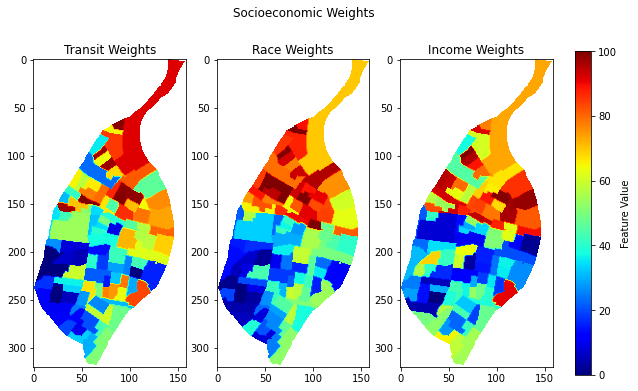

In [22]:
# Plot Classified Image 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6))
#ax0, ax1, ax2, ax3, ax4, ax5 = ax.flatten()
ax0, ax1, ax2, = ax.flatten()

axArr = ax.flatten()
ax_index = 0
names = ['Night Lights','Distance To Parks','Population Density','Transit Weights','Race Weights','Income Weights']
#names = ['Transit Weights','Race Weights','Income Weights']

for i in range(3):
    img = axArr[ax_index].imshow(feature_mat[:, :, i+3], cmap='jet')
    axArr[ax_index].set_title(names[i+3])
    ax_index += 1
cbar = fig.colorbar(img, ax=axArr, orientation='vertical', fraction=0.029, pad=0.04)
cbar.set_label('Feature Value')  

fig.suptitle('Socioeconomic Weights')
#plt.savefig('outputs\InputFeaturesSVR.png')
plt.savefig('outputs\Weights.png')
plt.show()


In [19]:
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

In [15]:
td_df = gpd.GeoDataFrame(td_gdf)
td_df.head()

,OBJECTID,transit1,race,income,StlPop_30m,NightLight,EucDist_pa,CID_bin_fm,NRSA_bin,TDD_lin_Cl,SBDs_bin_f,TransitWei,IncomeWeig,RaceWeigh
0,1,0.011853,0.011104,0.009674,43.286573,68.236473,78.857715,0,1,0,0,65.831663,82.464930,63.026052
1,2,0.017765,0.011035,0.009694,0.000000,26.152305,21.042084,0,0,0,0,75.851703,97.995992,60.220441
2,3,0.021888,0.009415,0.009679,0.000000,0.000000,16.733467,0,0,0,0,84.869739,88.877756,51.503006
3,4,0.001672,0.007478,0.009471,0.000000,46.492986,31.863727,0,0,0,0,14.128257,2.505010,21.342685
4,5,0.002610,0.007746,0.009604,98.797595,65.130261,46.092184,0,1,0,0,24.448898,37.074148,24.448898


In [19]:
# calculate class labels (index)

# Extract the specified columns from td_df
selected_columns = ['IncomeWeig', 'RaceWeigh', 'TransitWei']
# Add the values of 'IncomeWeigh', 'RaceWeigh', and 'TransitWei' element-wise
sum_row = td_df[['CID_bin_fm', 'NRSA_bin', 'TDD_lin_Cl','SBDs_bin_f']].sum(axis=1)
# Append the sum row to td_df
td_df['Labels'] = sum_row.values
td_df = td_df.drop(columns = ['CID_bin_fm', 'NRSA_bin', 'TDD_lin_Cl','SBDs_bin_f'])

#td_df['Labels'] = np.ones(500)
#td_df = td_df.drop(columns = 'CZID')
# Reset the index to ensure it's continuous
td_df.reset_index(drop=True, inplace=True)

td_df.head()

,OBJECTID,transit1,race,income,StlPop_30m,NightLight,EucDist_pa,TransitWei,IncomeWeig,RaceWeigh,Labels
0,1,0.012,0.011,0.010,43.287,68.236,78.858,65.832,82.465,63.026,1
1,2,0.018,0.011,0.010,0.000,26.152,21.042,75.852,97.996,60.220,0
2,3,0.022,0.009,0.010,0.000,0.000,16.733,84.870,88.878,51.503,0
3,4,0.002,0.007,0.009,0.000,46.493,31.864,14.128,2.505,21.343,0
4,5,0.003,0.008,0.010,98.798,65.130,46.092,24.449,37.074,24.449,1


In [24]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [25]:
# Assuming td_df is your DataFrame and 'StlPop_fm' is a column name
n_samples, n_features = td_df.shape[0], td_df.shape[1]-2
start = td_df.columns.get_loc('StlPop_30m')
X = td_df.iloc[:, start:-1]

y = td_df.iloc[:,-1]  # Class labels
display(X)
display(y)


,StlPop_30m,NightLight,EucDist_pa,CID_bin_fm,NRSA_bin,TDD_lin_Cl
0,43.287,68.236,78.858,0,1,0
1,0.000,26.152,21.042,0,0,0
2,0.000,0.000,16.733,0,0,0
3,0.000,46.493,31.864,0,0,0
4,98.798,65.130,46.092,0,1,0
5,0.000,76.052,53.006,0,0,0
6,82.966,33.066,70.741,0,0,0
7,57.916,16.633,82.365,0,0,0
8,52.705,73.948,66.834,0,0,0
9,89.579,35.070,22.846,0,0,0


0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     1
47     1
48     0
49     0
50     0
51     0
52     0
53     0
54     0
55     0
56     0
57     0
58     0
59     0
60     0
61     0
62     0
63     0
64     0
65     0
66     0
67     0
68     1
69     0
70     1
71     0
72     0
73     0
74     0
75     0
76     0
77     0
78     0
79     0
80     0
81     0
82     0
83     0
84     0
85     0
86     0
87     0
88     0
89     0
90     1
91     0
92     0
93     0
94     0
95     0
96     0
97     0
98     0
99     0
100    0
101    0
102    0
103    0
104    0
105    0
106    0
107    0
108    0
109    0
110    0
1

In [26]:
#hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svr = SVR()

# Define the grid of hyperparameters to search
param_grid = {
    "kernel": ["rbf"],
    "C": [1,10,10,100,1000],
    "gamma": [1e-12,1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5],
    "epsilon":[0.001, 0.01, 0.1, 0.2, 0.3]
    }

# Initialize GridSearchCV with the SVR regressor and hyperparameter grid
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=10)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set using mean squared error (MSE)
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(y_pred)

print("Best hyperparameters:", best_params)
print("Mean Squared Error on test set:", mse)


[0.05683768 0.00431101 0.05684432 0.05684432 0.05684417 0.05684497
 0.05684432 0.05684432 0.05684432 0.03215602 0.05684432 0.05684432
 0.05684432 0.00117269 0.05684432 0.05684432 0.05684432 0.05684432
 0.05684432 0.05684432 0.05684432 0.05684432 0.05684423 0.05684432
 0.05666611 0.05684332 0.05684432 0.05684432 0.0568443  0.05684432
 0.05684432 0.05684432 0.05684432 0.05684432 0.03916091 0.05684432
 0.0012083  0.05684432 0.05684432 0.05684432 0.05684432 0.05202245
 0.0568441  0.05684432 0.05684423 0.05684241 0.05684432 0.05684432
 0.05684432 0.05647646 0.05684432 0.05684432 0.0568439  0.05684432
 0.05684431 0.05684432 0.05684406 0.05684432 0.05684432 0.05684432
 0.05684432 0.05684432 0.05684432 0.05684432 0.05684432 0.05683894
 0.05684432 0.05684432 0.05684432 0.05684432 0.05684432 0.0568443
 0.05684432 0.05684432 0.05684431 0.00106135 0.05684432 0.05684432
 0.05684432 0.05652586 0.000994   0.05684432 0.05684432 0.05684432
 0.05684432 0.05684432 0.05684432 0.05684432 0.05684432 0.05684

In [27]:
regr = make_pipeline(StandardScaler(), SVR(C=1, epsilon=0.1, gamma = 1e-3, kernel = 'rbf'))
regr.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=1, gamma=0.001))])

Text(0.5, 0, 'Feature-wise Permutation Importance')

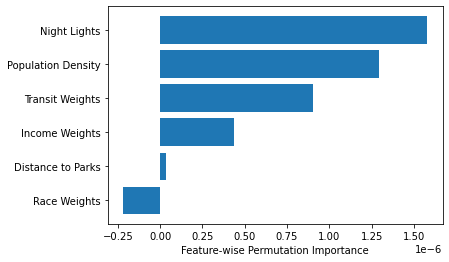

In [28]:
# perform permutation importance
from sklearn.inspection import permutation_importance

importance = permutation_importance(regr, X, y, scoring='neg_mean_squared_error')

feature_names = ['Population Density', 'Night Lights', 'Transit Weights','Income Weights','Race Weights','Distance to Parks']
features = np.array(feature_names)

sorted_idx = importance.importances_mean.argsort()
plt.barh(features[sorted_idx], importance.importances_mean[sorted_idx])
plt.xlabel("Feature-wise Permutation Importance")

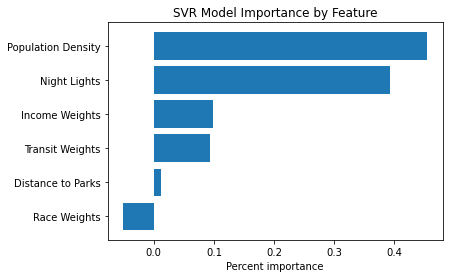

In [29]:
importance = permutation_importance(regr, X, y, scoring='neg_mean_squared_error')

feature_names = ['Population Density', 'Night Lights', 'Transit Weights','Income Weights','Race Weights','Distance to Parks']
features = np.array(feature_names)

sorted_idx = importance.importances_mean.argsort()
normalized_importances = importance.importances_mean[sorted_idx] / np.sum(importance.importances_mean[sorted_idx])  # Normalizing

plt.barh(features[sorted_idx], normalized_importances)
plt.xlabel("Percent importance")
plt.title('SVR Model Importance by Feature')
plt.savefig('outputs\ImportanceSVR.png')
plt.show()

In [30]:
m,n, h = feature_mat.shape
print('m: ',m,'n: ',n,'h: ',h)

m:  320 n:  159 h:  6


In [31]:
feature_mat_flat = feature_mat.reshape(m*n,h)
featdf = pd.DataFrame(feature_mat_flat)
#display(featdf)

In [32]:
import time
import numpy as np

start_time = time.time()  # Start timing

# Define batch size
batch_size = 100

print(feature_mat_flat.shape)
i = 0
assignments = []

for pix in feature_mat_flat:
  #  print(pix)
    if np.isnan(pix).any():  # Check if any NaN values are present
        pred = -1
    else:
        pred = regr.predict(pix.reshape(1, -1))
    
    assignments.append(pred)

    if i % 1000 == 0:
        # print(pix)
        print('pix:', i, 'prediction:', pred)
    
    i += 1
    
# End timing
end_time = time.time()
execution_time = end_time - start_time


(50880, 6)
pix: 0 prediction: -1
pix: 1000 prediction: -1
pix: 2000 prediction: -1
pix: 3000 prediction: [0.10385749]
pix: 4000 prediction: -1
pix: 5000 prediction: -1
pix: 6000 prediction: -1
pix: 7000 prediction: -1
pix: 8000 prediction: -1
pix: 9000 prediction: -1
pix: 10000 prediction: -1
pix: 11000 prediction: -1
pix: 12000 prediction: [0.10385749]
pix: 13000 prediction: -1
pix: 14000 prediction: -1
pix: 15000 prediction: -1
pix: 16000 prediction: [0.10385749]
pix: 17000 prediction: -1
pix: 18000 prediction: -1
pix: 19000 prediction: [0.10385749]
pix: 20000 prediction: [0.10385749]
pix: 21000 prediction: -1
pix: 22000 prediction: [0.10385749]
pix: 23000 prediction: [0.10385749]
pix: 24000 prediction: -1
pix: 25000 prediction: [0.10385749]
pix: 26000 prediction: [0.10385749]
pix: 27000 prediction: [0.10385749]
pix: 28000 prediction: -1
pix: 29000 prediction: [0.10385749]
pix: 30000 prediction: [0.10385749]
pix: 31000 prediction: -1
pix: 32000 prediction: [0.10385749]
pix: 33000 pre

In [33]:
print(f"Execution time: {execution_time} seconds")

Execution time: 10.72519564628601 seconds


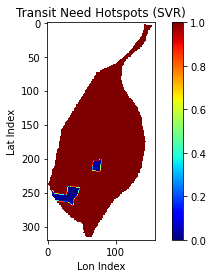

In [34]:
assignments_fixed = []

# Iterate through the predictions
for pred in assignments:
    if isinstance(pred, list):  # Check if pred is a list or array
        assignments_fixed.extend(pred)  # Unpack the list and append its elements
    elif pred == -1:
        assignments_fixed.append(np.nan)  # Replace -1 with NaN
    else:
        assignments_fixed.append(pred)  # Keep the value unchanged

assignmentsArr = np.array(assignments_fixed, dtype='object')
lc = assignmentsArr.reshape(m, n)
 
lcn = scaler.fit_transform(lc.reshape(-1, 1)).reshape(-1)
lcn = lcn.reshape(m,n)

#normalize classified image 
lc_float = lcn.astype(float)
img_class = plt.imshow(lc_float, cmap='jet')
plt.title('Transit Need Hotspots (SVR)')
plt.xlabel('Lon Index')
plt.ylabel('Lat Index')
plt.colorbar(img_class)
plt.savefig('outputs\ClassifiedSVR.png')
plt.show()

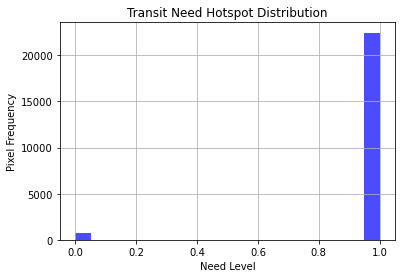

In [35]:
# Flatten the 2D array lc to a 1D array
lc_flattened = lcn.flatten()
# Plot histogram
plt.hist(lc_flattened, bins=20, color='blue', alpha=0.7)
plt.title('Transit Need Hotspot Distribution')
plt.xlabel('Need Level')
plt.ylabel('Pixel Frequency')
plt.grid(True)
plt.savefig('outputs\ClassesHist.png')
plt.show()

Mask out all values that are less than 0.8 to identify areas of most need.

In [36]:
need = lcn>0.8
mask = np.copy(lcn)
mask[~need] = np.nan
mask = mask.reshape(m,n)

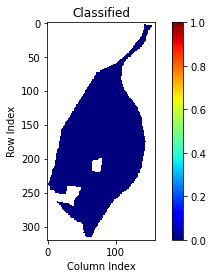

In [37]:
needPlot = plt.imshow(mask, cmap='jet')
plt.title('Classified')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.colorbar(img_class)
plt.show()

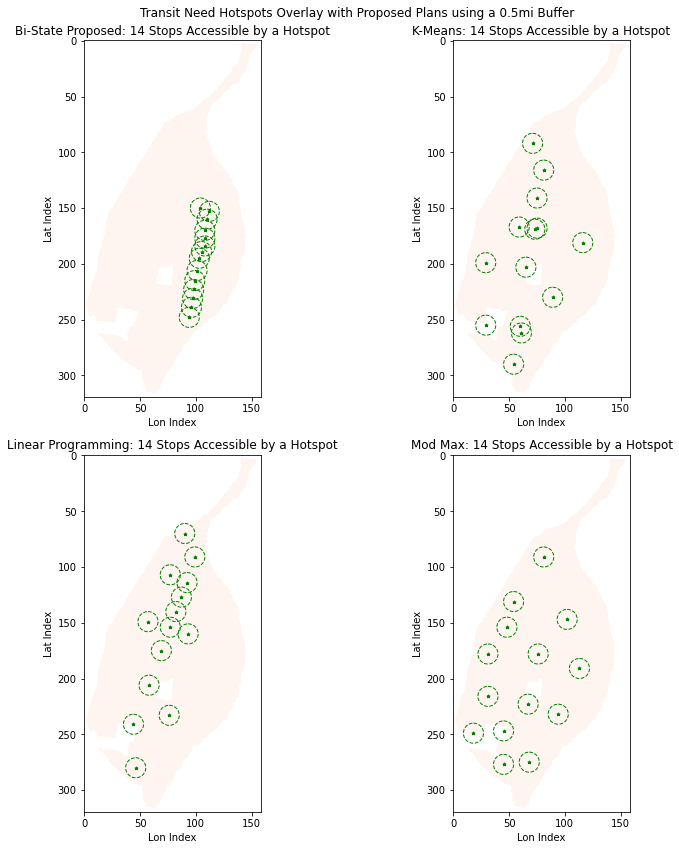

In [38]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Proj, Transformer
from matplotlib.patches import Circle

shapefile_paths = [r"plans\OrigStops.shp",r"plans\KMeansStops.shp",r"plans\LPStops.shp",r"plans\MMStops.shp"]
plan_names = ['Bi-State Proposed', 'K-Means','Linear Programming','Mod Max']
boundary = gpd.read_file(r"districts/stl_boundary.shp", crs='EPSG:4326')

# Plotting code

approx_km_per_degree_lat = 111.0  # Approximate value for latitude conversion (km/degree)
km_to_feet = 3280.84  # Conversion factor from kilometers to feet

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

with rasterio.open(r"RawRasters\NightLightsStl.tif") as src:
    data = src.read(1)  
    data_ext = src.bounds  # Get the extent of the raster in the CRS of the raster

# Create a transformer to transform from the raster CRS to EPSG 4326
transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)

# Transform the bounding box coordinates to EPSG 4326
min_lon, min_lat = transformer.transform(data_ext.left, data_ext.bottom)
max_lon, max_lat = transformer.transform(data_ext.right, data_ext.top)

data_ext_4326 = (min_lon, min_lat, max_lon, max_lat)

overlap_count = [] 

for i, shapefile_path in enumerate(shapefile_paths):
    data = gpd.read_file(shapefile_path)
    data = data.to_crs("EPSG:4326")  # Reproject to target CRS

    # Collocate points to array indices
    count = 0
    collocated_points = []
    for idx, row in data.iterrows():
        lon, lat = row.geometry.x, row.geometry.y
        col = int((lon - data_ext_4326[0]) / ((data_ext_4326[2] - data_ext_4326[0]) / n))
        row = int((data_ext_4326[3] - lat) / ((data_ext_4326[3] - data_ext_4326[1]) / m))
        collocated_points.append((col, row))
        
        radius_feet = 5280//2  # Example radius in feet, replace with your desired value
        radius_degrees = radius_feet / (approx_km_per_degree_lat * km_to_feet)
        radius_indices = int(radius_degrees * mask.shape[0] / (data_ext_4326[3] - data_ext_4326[1]))
        
        # Create circular buffer mask
        y, x = np.ogrid[-row:m - row, -col:n - col]
        mask_circle = x ** 2 + y ** 2 <= radius_indices ** 2

        # Increment count if any non-NaN value is found within the circular buffer
        if not np.isnan(mask[mask_circle]).all():
            count += 1

        # Plot circular buffer as a vector circle outline
        circle = Circle((col, row), radius_indices, edgecolor='green', facecolor='none', linestyle='--')
        axs[i // 2, i % 2].add_patch(circle)

    overlap_count.append(count)  # Add count to the list
    
    #axs[i // 2, i % 2].plot(boundary, edgecolor = 'black')
    img = axs[i // 2, i % 2].imshow(mask, cmap='Reds')
    axs[i // 2, i % 2].scatter([col for col, _ in collocated_points], [row for _, row in collocated_points],
                                marker='*', color='green', s=10)
    axs[i // 2, i % 2].set_title(f"{plan_names[i]}: {overlap_count[i]} Stops Accessible by a Hotspot")
    axs[i // 2, i % 2].set_xlabel('Lon Index')
    axs[i // 2, i % 2].set_ylabel('Lat Index')


#cbar = fig.colorbar(img, ax=axs, orientation='vertical', pad=1)
#cbar.set_label('Need') 
fig.suptitle('Transit Need Hotspots Overlay with Proposed Plans using a 0.5mi Buffer')
plt.tight_layout()

plt.savefig('outputs\OverlaySVR.png')
plt.show()


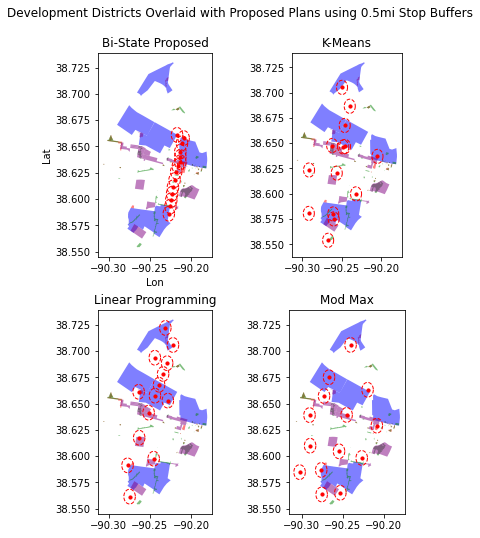

In [66]:
file_paths = [
    "districts/TDD.shp",
    "districts/NRSA.shp",
    "districts/CID.shp",
    "districts/SBD.shp"
]

dists = [gpd.read_file(file, crs='EPSG:4326') for file in file_paths]
colors = ['red', 'blue', 'green', 'purple']
dist_names = ['TDD', 'NRSA', 'CID', 'SBD']  # Assuming you have the plan names defined somewhere
shapefile_paths = [r"plans\OrigStops.shp",r"plans\KMeansStops.shp",r"plans\LPStops.shp",r"plans\MMStops.shp"]
plan_names = ['Bi-State Proposed', 'K-Means','Linear Programming','Mod Max']

lat_deg_to_mi = 69  # Approximation for latitude conversion from degrees to miles
lon_deg_to_mi = 69  
r = 0.007

id = 0
data = []  # List to store data for each district and plan

for id, plan_name in enumerate(plan_names):
    for dist, name in zip(dists, dist_names):
        total_area_deg = dist.area.sum()  
        total_area_mi = total_area_deg * lat_deg_to_mi * lon_deg_to_mi  
        
        stops = gpd.read_file(shapefile_paths[id])
        stops = stops.to_crs("EPSG:4326")
        stops_buffer = stops.buffer(r)  
        stops_buffer_df = gpd.GeoDataFrame(geometry=stops_buffer) 
        
        overlap = gpd.overlay(dist, stops_buffer_df, how='intersection') 
        overlap_area_mi = overlap.area.sum() * lat_deg_to_mi * lon_deg_to_mi 
        
        not_covered_area_mi = total_area_mi - overlap_area_mi  

        
        data.append({'District': name,
                     'Plan Name': plan_name,
                     'Total Area (mi)': total_area_mi,
                     'Overlap Area (mi)': overlap_area_mi,
                     'Uncovered Area (mi)': not_covered_area_mi})

zonalStats_dists = pd.DataFrame(data)
sum_row = pd.Series(zonalStats_dists.sum(numeric_only=True), name='Total')
zonalStats_dists = zonalStats_dists.append(sum_row)
plan_totals = zonalStats_dists.groupby('Plan Name').sum()

######################################################################plot!
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

name = 0
for ax in axs.flat:
    stops = gpd.read_file(shapefile_paths[name])
    stops = stops.to_crs("EPSG:4326")
    col = 0
    for dist in dists:
        dist.plot(ax=ax, color=colors[col], alpha=0.5, label=dist_names[col])
        col += 1

    stops_buffer = stops.buffer(r)
    stops_buffer.plot(ax=ax, edgecolor='red', facecolor='none', linestyle='--')
    stops.plot(ax=ax, markersize=10, color='red', marker='o', label='Stops')
    ax.set_title(plan_names[name])
    name += 1
    if name == 1:
        ax.set_xlabel('Lon')
        ax.set_ylabel('Lat')
fig.suptitle(f'Development Districts Overlaid with Proposed Plans using 0.5mi Stop Buffers')
plt.tight_layout()
plt.subplots_adjust(left=0.21, right=0.82, top=0.9, bottom=0.1)
plt.savefig('outputs\OverlayDists.png')

plt.show()

In [40]:
#plan_totals = plan_totals.drop(columns = 'Total Area (mi)')
plan_totals['Percent Covered Land'] = (plan_totals['Overlap Area (mi)'] / plan_totals['Total Area (mi)']) * 100
plan_totals = plan_totals.drop(columns = ['Total Area (mi)'])
plan_totals.head()
#display(zonalStats_dists)

,Overlap Area (mi),Uncovered Area (mi),Percent Covered Land
Plan Name,,,
Bi-State Proposed,3.712,20.564,15.292
K-Means,4.981,19.295,20.520
Linear Programming,4.212,20.064,17.351
Mod Max,2.422,21.855,9.975


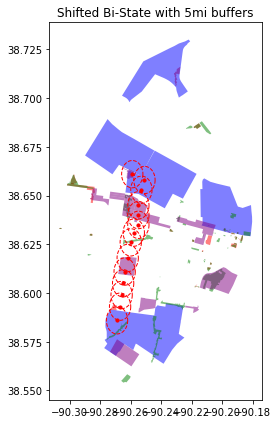

In [41]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

shapefile_path = r"plans\NudgedOrigStops.shp"
plan_name = 'Nudge'

file_paths = [
    "districts/TDD.shp",
    "districts/NRSA.shp",
    "districts/CID.shp",
    "districts/SBD.shp"
]

dists = [gpd.read_file(file, crs='EPSG:4326') for file in file_paths]
dist_names = ['TDD', 'NRSA', 'CID', 'SBD']

lat_deg_to_mi = 69  # Approximation for latitude conversion from degrees to miles
lon_deg_to_mi = 69  
r = 0.007

id = 0
data = []

# Calculate areas and store data for each district
for dist, name in zip(dists, dist_names):
    total_area_deg = dist.area.sum()  
    total_area_mi = total_area_deg * lat_deg_to_mi * lon_deg_to_mi  
    
    stops = gpd.read_file(shapefile_path)
    stops = stops.to_crs("EPSG:4326")
    stops_buffer = stops.buffer(r)  
    stops_buffer_df = gpd.GeoDataFrame(geometry=stops_buffer) 
    
    overlap = gpd.overlay(dist, stops_buffer_df, how='intersection') 
    overlap_area_mi = overlap.area.sum() * lat_deg_to_mi * lon_deg_to_mi 
    
    not_covered_area_mi = total_area_mi - overlap_area_mi  
    percent_overlap = (overlap_area_mi / total_area_mi) * 100
    
    data.append({'District': name,
                 'Total Area (mi)': total_area_mi,
                 'Overlap Area (mi)': overlap_area_mi,
                 'Uncovered Area (mi)': not_covered_area_mi})

zonalStats_dists_nudge = pd.DataFrame(data)
#sum_row = pd.Series(zonalStats_dists_nudge.sum(numeric_only=True), name='Total')
zonalStats_dists_nudge = zonalStats_dists_nudge.append(sum_row)

######################################################################
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

stops = gpd.read_file(shapefile_path)
stops = stops.to_crs("EPSG:4326")

col = 0
for dist in dists:
    dist.plot(ax=ax, color=colors[col], alpha=0.5, label=dist_names[col])
    col += 1

stops_buffer = stops.buffer(r)
stops_buffer.plot(ax=ax, edgecolor='red', facecolor='none', linestyle='--')
stops.plot(ax=ax, markersize=10, color='red', marker='o', label='Stops')

ax.set_title('Shifted Bi-State with 5mi buffers')
plt.tight_layout()
plt.savefig('outputs\OverlayDistsNudge.png')
plt.show()

In [42]:
zonalStats_dists_nudge['Percent Covered Land'] = (zonalStats_dists_nudge['Overlap Area (mi)'] / zonalStats_dists_nudge['Total Area (mi)']) * 100

display(zonalStats_dists_nudge)

,District,Total Area (mi),Overlap Area (mi),Uncovered Area (mi),Percent Covered Land
0,TDD,0.477,0.065,0.412,13.596
1,NRSA,17.659,2.829,14.830,16.018
2,CID,1.675,0.238,1.437,14.227
3,SBD,4.465,2.169,2.297,48.567
Total,NaN,97.106,15.328,81.778,15.784


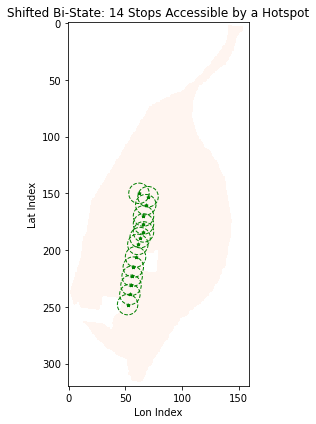

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))

shapefile_path = r"plans\NudgedOrigStops.shp"
data = gpd.read_file(shapefile_path)
data = data.to_crs("EPSG:4326")  # Reproject to target CRS
count = 0
collocated_points = []
for idx, row in data.iterrows():
    lon, lat = row.geometry.x, row.geometry.y
    col = int((lon - data_ext_4326[0]) / ((data_ext_4326[2] - data_ext_4326[0]) / n))
    row = int((data_ext_4326[3] - lat) / ((data_ext_4326[3] - data_ext_4326[1]) / m))
    collocated_points.append((col, row))

    # Plotting code
    radius_feet = 5280 // 2  # Example radius in feet, replace with your desired value
    radius_degrees = radius_feet / (approx_km_per_degree_lat * km_to_feet)
    radius_indices = int(radius_degrees * mask.shape[0] / (data_ext_4326[3] - data_ext_4326[1]))
    
    y, x = np.ogrid[-row:m - row, -col:n - col]
    mask_circle = x ** 2 + y ** 2 <= radius_indices ** 2

    # Increment count if any non-NaN value is found within the circular buffer
    if not np.isnan(mask[mask_circle]).all():
        count += 1

    circle = Circle((col, row), radius_indices, edgecolor='green', facecolor='none', linestyle='--')
    ax.add_patch(circle)
ax.scatter([col for col, _ in collocated_points], [row for _, row in collocated_points],
                                marker='*', color='green', s=10)

# Plot other elements as needed
img = ax.imshow(mask, cmap='Reds')
ax.set_title(f"Shifted Bi-State: {count} Stops Accessible by a Hotspot")
ax.set_xlabel('Lon Index')
ax.set_ylabel('Lat Index')

#fig.suptitle('Transit Need Hotspots Overlay with Nudged Plan Plan using a 0.5mi Buffer')
plt.tight_layout()

plt.savefig('outputs\OverlaySVRNudge.png')
plt.show()